##***MUSIC CONDITIONED DANCE GENRATION***



##Variational Autoencoder

In [ ]:
import tensorflow as tf
#!pip install moviepy

In [ ]:
# Import necessary libraries
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

# Set the input and output file paths
input_video_path = '/content/drive/MyDrive/x2mate.com-Techno_Tech House Mix by DJ Haluk Arslan with Shadow Dancers-(480p).mp4'  # Replace with the path to your video file
output_video_path = '/content/drive/MyDrive/sample_video.mp4'

# Define the start and end times for the trim (5 minutes in seconds)
start_time = 0
end_time = 300  # 5 minutes * 60 seconds/minute

# Trim the video
ffmpeg_extract_subclip(input_video_path, start_time, end_time, targetname=output_video_path)

# Display a message when the trimming is complete
print("Video trimmed and saved as 'sample_video.mp4'.")


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Video trimmed and saved as 'sample_video.mp4'.


In [ ]:
import cv2
import numpy as np

VIDEO_PATH = '/content/drive/MyDrive/sample_video.mp4'
kernel = np.ones((2,2),np.uint8)
cap = cv2.VideoCapture(VIDEO_PATH)

data = []
count = 1
limit = 0
while(cap.isOpened()):
	ret, image_np = cap.read()
	if ret == False:
		break
	if limit == 3:
		limit = 0
		image_np = 255 - image_np
		image_np = cv2.resize(image_np,(208,120))
		ret,image_np = cv2.threshold(image_np,127,255,cv2.THRESH_BINARY)
		bg_index = np.where(np.greater(image_np,20))
		image_np[bg_index] = 255
		image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
		(T, thresh) = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY)
		cv2.imwrite("/content/imgs/{}.jpg".format(count),image_np)
		print("{}.jpg".format(count))
		count += 1
	limit += 1

In [ ]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
import cv2
import os

latent_dim = 128
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


input_img = Input(shape=(120,208,1))
x = Conv2D(filters=128,kernel_size=3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64,kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32,kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(128,kernel_initializer='glorot_uniform')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean,z_log_var])

encoder = Model(input_img, [z_mean, z_log_var,z], name="encoder")
encoder.summary()


latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], kernel_initializer='glorot_uniform',activation='relu')(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)
x = Dense(128,kernel_initializer='glorot_uniform')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=64,kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=128,kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=1,kernel_size=3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs,x,name='decoder')

decoder.summary()


outputs = decoder(encoder(input_img)[2])
print(outputs.shape)
vae = Model(input_img,outputs,name="vae")

def data_generator(batch_size,limit):

	batch = []
	counter = 1
	while 1:
		for i in range(1,limit+1):
			if counter >= limit:
				counter = 1
			img = cv2.imread("/content/imgs/{}.jpg".format(counter),cv2.IMREAD_GRAYSCALE)
			img = img.reshape(120,208,1)
			batch.append(img)
			if len(batch) == batch_size:
				batch_np = np.array(batch) / 255
				batch = []
				yield (batch_np,None)
			counter += 1

if __name__ == '__main__':

	reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
	reconstruction_loss *= 120 * 208
	kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
	kl_loss = K.sum(kl_loss,axis=-1)
	kl_loss *= -0.5
	vae_loss = K.mean(reconstruction_loss + kl_loss)
	vae.add_loss(vae_loss)
	vae.compile(optimizer='rmsprop', loss = None)
	vae.summary()
	checkpoint = ModelCheckpoint('./weights/vae_cnn.h5', verbose=1,monitor='loss', save_best_only=True, mode='auto',period=1)
	callbacks= [checkpoint]
	batch_size = 100
	limit = len(os.listdir('/content/imgs'))
	spe = int(limit/batch_size)
	print(limit,spe)
	vae.fit_generator(data_generator(batch_size,limit),epochs=50, steps_per_epoch=spe,callbacks=callbacks)
	vae.save_weights('vae_cnn.h5')

In [ ]:
import tensorflow as tf
from keras import backend as K
import os
import numpy as np
import cv2


vae.load_weights('/content/vae_cnn.h5')
data =[]
lv_array = []
limit = len(os.listdir('/content/imgs'))

for i in range(1,limit):
	img = cv2.imread('/content/imgs/{}.jpg'.format(i),cv2.IMREAD_GRAYSCALE)
	img = cv2.resize(img,(208,120))
	data_np = np.array(img) / 255
	data_np = data_np.reshape(1,120,208,1)
	lv = encoder.predict(data_np)[2]
	lv_array.append(lv)

print(np.array(lv_array).shape)
np.save("lv.npy",np.array(lv_array))

In [ ]:
len(lv_array)


2996

In [ ]:
import tensorflow as tf
import numpy as np
#from model import decoder,vae
import cv2

vae.load_weights("vae_cnn.h5")
lv = np.load("lv.npy")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter("output.avi", fourcc, 30.0, (208, 120))

for i in range(1000):
    data = lv[i].reshape(1,128)
    img = decoder.predict(data)
    img = np.array(img).reshape(120,208,1)
    img = img * 255
    img = np.array(img).astype("uint8")
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    video.write(img)
video.release()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


In [ ]:
import keras
from keras import backend as K
from keras.layers import Dense
from keras.layers import Layer
import numpy as np
import tensorflow as tf


def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)


class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.

    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dimension, num_mixtures, **kwargs):
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        with tf.name_scope('MDN'):
            self.mdn_mus = Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas')  # mix*output vals exp activation
            self.mdn_pi = Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self._trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self._non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x),
                                                self.mdn_sigmas(x),
                                                self.mdn_pi(x)],
                                               name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        }
        base_config = super(MDN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def get_mixture_loss_func(output_dim, num_mixes):
      """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
      def loss_func(y_true, y_pred):
            out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                            num_mixes * output_dim,
                                                                            num_mixes],
                                                axis=1, name='mdn_coef_split')
            cat = tfd.Categorical(logits=out_pi)
            component_splits = [output_dim] * num_mixes
            mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
            sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
            coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                    in zip(mus, sigs)]
            mixture = tfd.Mixture(cat=cat, components=coll)
            loss = mixture.log_prob(y_true)
            loss = tf.negative(loss)
            loss = tf.reduce_mean(loss)
            return loss

    # Actually return the loss_func
      with tf.name_scope('MDN') as scope:
          return loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
        """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
        # Construct a loss function with the right number of mixtures and outputs
        def sampling_func(y_pred):
            out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                            num_mixes * output_dim,
                                                                            num_mixes],
                                                axis=1, name='mdn_coef_split')
            cat = tfd.Categorical(logits=out_pi)
            component_splits = [output_dim] * num_mixes
            mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
            sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
            coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                    in zip(mus, sigs)]
            mixture = tfd.Mixture(cat=cat, components=coll)
            samp = mixture.sample()
            # Todo: temperature adjustment for sampling function.
            return samp

        # Actually return the loss_func
        with tf.name_scope('MDNLayer') as scope:
            return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
        """Construct an MSE accuracy function for the MDN layer
        that takes one sample and compares to the true value."""
        # Construct a loss function with the right number of mixtures and outputs
        def mse_func(y_true, y_pred):
            out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                            num_mixes * output_dim,
                                                                            num_mixes],
                                                axis=1, name='mdn_coef_split')
            cat = tfd.Categorical(logits=out_pi)
            component_splits = [output_dim] * num_mixes
            mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
            sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
            coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                    in zip(mus, sigs)]
            mixture = tfd.Mixture(cat=cat, components=coll)
            samp = mixture.sample()
            mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
            # Todo: temperature adjustment for sampling functon.
            return mse

        # Actually return the loss_func
        with tf.name_scope('MDNLayer') as scope:
            return mse_func


def split_mixture_params(params, output_dim, num_mixes):
        """Splits up an array of mixture parameters into mus, sigmas, and pis
        depending on the number of mixtures and output dimension."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pi_logits = params[-num_mixes:]
        return mus, sigs, pi_logits


def softmax(w, t=1.0):
        """Softmax function for a list or numpy array of logits. Also adjusts temperature."""
        e = np.array(w) / t  # adjust temperature
        e -= e.max()  # subtract max to protect from exploding exp values.
        e = np.exp(e)
        dist = e / np.sum(e)
        return dist


def sample_from_categorical(dist):
        """Samples from a categorical model PDF."""
        r = np.random.rand(1)  # uniform random number in [0,1]
        accumulate = 0
        for i in range(0, dist.size):
            accumulate += dist[i]
            if accumulate >= r:
                return i
        tf.logging.info('Error sampling mixture model.')
        return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ENCODED_DATA_PATH = '/content/lv.npy'
VAE_PATH = '/content/vae_cnn.h5'
DANCENET_PATH = '/content/drive/MyDrive/gendance (1).h5'

In [ ]:
data = np.load(ENCODED_DATA_PATH)
print(data.shape)

(2996, 1, 128)


In [ ]:
data = np.array(data).reshape(-1,128)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data)
data =  scaler.transform(data)

In [ ]:
numComponents = 24
outputDim = 128

In [ ]:
mdn=MDN(outputDim, numComponents)

In [ ]:
inputs = Input(shape=(128,))
x = Reshape((1,128))(inputs)
x = LSTM(512, return_sequences=True,input_shape=(1,128))(x)
x = Dropout(0.40)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.40)(x)
x = LSTM(512)(x)
x = Dropout(0.40)(x)
x = Dense(1000,activation='relu')(x)
outputs = mdn(x)
model = Model(inputs=inputs,outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1312768   
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            2099200   
                                                                 
 dropout_1 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               209920

In [ ]:
opt = Adam(lr=0.0005)
model.compile(loss=get_mixture_loss_func(outputDim,numComponents),optimizer=opt)

In [ ]:
train = False #change to True to train from scratch

if train:
    X = data[0:len(data)-1]
    Y = data[1:len(data)]
    checkpoint = ModelCheckpoint(DANCENET_PATH, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    model.fit(X,Y,batch_size=1024, verbose=1, shuffle=False, validation_split=0.20, epochs=10000, callbacks=callbacks_list)

In [ ]:
vae.load_weights(VAE_PATH)
model.load_weights(DANCENET_PATH)

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("out.mp4", fourcc, 30.0, (208, 120))
lv_in = data[0]

for i in range(500):
    input = np.array(lv_in).reshape(1,128)
    lv_out = model.predict(input)
    shape = np.array(lv_out).shape[1]
    lv_out = np.array(lv_out).reshape(shape)
    lv_out = sample_from_output(lv_out,128,numComponents,temp=0.01)
    lv_out = scaler.inverse_transform(lv_out)
    img = decoder.predict(np.array(lv_out).reshape(1,128))
    img = np.array(img).reshape(120,208,1)
    img = img * 255
    img = np.array(img).astype("uint8")
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    lv_in = lv_out
    video.write(img)
video.release()

##RNN

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 48.5 MB/s eta 0:00:00


##Mediapipe Pose Estimation

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
import pandas as pd

In [ ]:
path = '/content/dance.mp4'

cap = cv2.VideoCapture(path)

# Getting video's width, height, and frames per second
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output_path = '/content/drive/MyDrive/dance1_coord.mp4'
file_path = '/content/drive/MyDrive/dance1_coord.txt'

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

coordinates = []

try:
    with open(file_path, 'w') as file:
        # Step 2: Write data to the file


# Step 3: Close the file

        with mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                ret, frame = cap.read()

                if not ret:
                    break

                # Recolor image to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Make detection
                results = pose.process(image)

                # Recolor back to BGR
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


                # white screen with stickman dance
                blank = np.ones((height, width, 3), np.uint8) * 255

                # Extract landmarks
                try:
                    landmarks = results.pose_landmarks.landmark
                    coordinates.append(landmarks)
                    #print(landmarks)
                    file.write(f"{landmarks}\n")

                except:
                    pass


                # Render detections
                mp.solutions.drawing_utils.draw_landmarks(blank, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS,
                                        mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                        mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                        )

                #cv2.imshow('hehe', image)

                # Write the frame to the output video
                output.write(blank)

#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break

            cap.release()
            output.release()
            #cv2.destroyAllWindows()

except IOError as e:
    print(f"Error: {e}")



In [ ]:
coordinates[0]

[x: 0.45759645104408264
y: 0.4054281413555145
z: 0.20501823723316193
visibility: 0.9995898604393005
, x: 0.45603567361831665
y: 0.4005364179611206
z: 0.20103003084659576
visibility: 0.9996391534805298
, x: 0.4548414647579193
y: 0.4008496403694153
z: 0.20102621614933014
visibility: 0.9996263980865479
, x: 0.4535934627056122
y: 0.4012482464313507
z: 0.2010248303413391
visibility: 0.9996360540390015
, x: 0.45918869972229004
y: 0.39918941259384155
z: 0.1950017213821411
visibility: 0.9994416832923889
, x: 0.4601220190525055
y: 0.398634135723114
z: 0.19500914216041565
visibility: 0.9993209838867188
, x: 0.46098792552948
y: 0.3981042504310608
z: 0.19497443735599518
visibility: 0.999168872833252
, x: 0.4518056809902191
y: 0.40476539731025696
z: 0.17564180493354797
visibility: 0.999639630317688
, x: 0.46172279119491577
y: 0.4004095196723938
z: 0.14837250113487244
visibility: 0.9991004467010498
, x: 0.45584383606910706
y: 0.41148608922958374
z: 0.19717490673065186
visibility: 0.9992777705192566


In [ ]:
data = []
for i in coordinates:
    point = []
    for j in i:
        x, y, z = j.x, j.y, j.z
        point.append(np.array((x,y,z)))
    data.append(np.array(point))

In [ ]:
data_arr = np.array(data)

In [ ]:
data_arr[0:2]

array([[[ 0.45759645,  0.40542814,  0.20501824],
        [ 0.45603567,  0.40053642,  0.20103003],
        [ 0.45484146,  0.40084964,  0.20102622],
        [ 0.45359346,  0.40124825,  0.20102483],
        [ 0.4591887 ,  0.39918941,  0.19500172],
        [ 0.46012202,  0.39863414,  0.19500914],
        [ 0.46098793,  0.39810425,  0.19497444],
        [ 0.45180568,  0.4047654 ,  0.1756418 ],
        [ 0.46172279,  0.40040952,  0.1483725 ],
        [ 0.45584384,  0.41148609,  0.19717491],
        [ 0.45930609,  0.41040891,  0.1891197 ],
        [ 0.4400804 ,  0.44311059,  0.12297027],
        [ 0.47082281,  0.41934794,  0.09260155],
        [ 0.42765546,  0.46356952,  0.05258301],
        [ 0.48111269,  0.37430021, -0.00248594],
        [ 0.4506706 ,  0.48433846, -0.01424343],
        [ 0.46260706,  0.3959651 , -0.07606672],
        [ 0.4557713 ,  0.48972794, -0.02489782],
        [ 0.4573786 ,  0.39580309, -0.08923903],
        [ 0.45653087,  0.49198478, -0.02694791],
        [ 0.45669332

In [ ]:
len(data_arr)

4297

In [ ]:
data_arr.shape

(4297, 33, 3)

In [ ]:
df1=pd.DataFrame(data_arr[0],columns=["x","y","Z"])

##Motion Vectors based on Motion Intensity

In [ ]:
import cv2
import numpy as np

# Load the dance video
video_path = 'dance.mp4'  
cap = cv2.VideoCapture(video_path)

# Initialize optical flow parameters
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors for visualizing optical flow
color = np.random.randint(0, 255, (100, 3))

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

motion_vectors = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is not None:
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Calculate motion vectors
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            motion_vectors.append([a - c, b - d])

        # Update the previous frame and points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

# Save motion vectors to a CSV file
import csv
with open('motion_features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(motion_vectors)

# Release the video capture
cap.release()
cv2.destroyAllWindows()


In [ ]:
motion_array=np.array(motion_vectors)

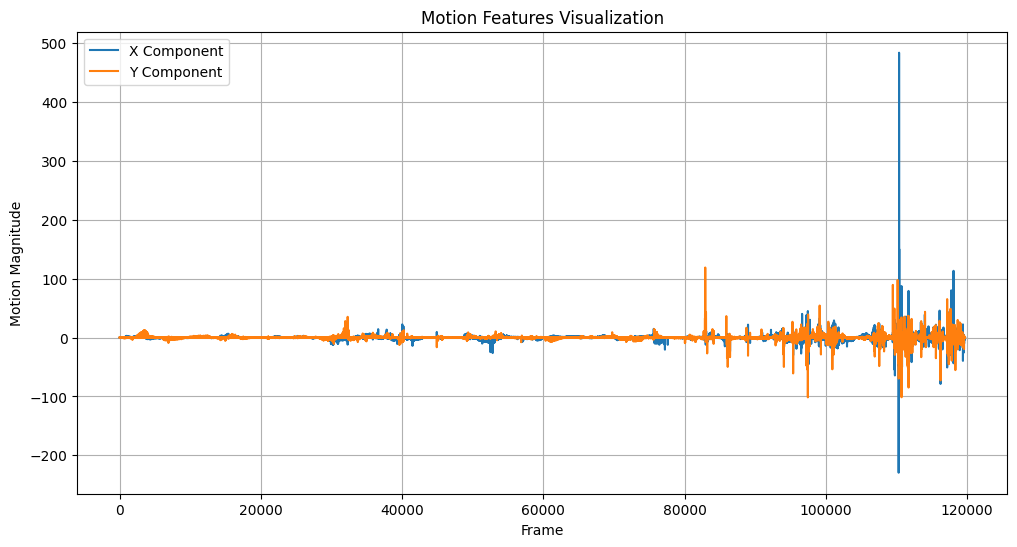

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the motion features from the CSV file
df = pd.read_csv('motion_features.csv')

# Split the motion vectors into X and Y components
motion_x = df.iloc[:, 0]
motion_y = df.iloc[:, 1]

# Create a plot to visualize the motion
plt.figure(figsize=(12, 6))

# Plot the X and Y components of motion
plt.plot(motion_x, label='X Component')
plt.plot(motion_y, label='Y Component')

# Customize the plot
plt.title('Motion Features Visualization')
plt.xlabel('Frame')
plt.ylabel('Motion Magnitude')
plt.legend()
plt.grid()

# Display the plot
plt.show()


##Transformer

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --")
        # Broadcasting add. So just the last N dimensions need to match
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x


class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
d_model = 3
num_heads = 3
ffn_hidden = 128
drop_prob = 0.1
num_layers = 6

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [ ]:
import tensorflow as tf

In [ ]:
data_arr.shape

(4297, 33, 3)

In [ ]:
pos_tensor = tf.constant(data_arr)
input_data=tf.expand_dims(pos_tensor, 0)

In [ ]:
pos_tensor.shape

TensorShape([4297, 33, 3])

In [ ]:
data_flatten=data_arr[0].flatten()

In [ ]:
pos_tensor[0].shape
pos_tensor1=tf.expand_dims(pos_tensor[0], 0)
pos_tensor2=tf.expand_dims(pos_tensor1, 0)

In [ ]:
pos_tensor2.shape

TensorShape([1, 1, 33, 3])

##CNN Motion Feature Encoding using CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder architecture
def create_encoder(input_shape, encoding_dim):
    model = models.Sequential()

    # Convolutional layers for feature extraction
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers for encoding
    model.add(layers.Dense(encoding_dim, activation='relu'))

    return model

# Define the input shape and encoding dimension
input_shape = (1, 33, 3)  # Input shape (4297, 33, 3)
encoding_dim = 64  # Desired encoding dimension (adjust as needed)

# Create the encoder model
encoder = create_encoder(input_shape, encoding_dim)
encoded_datalist=[]
# Load your 3D array data here (replace with your actual data)
for i in range(len(data_arr)):
    input_data = tf.constant(data_arr[i])
    input_data=tf.expand_dims(input_data, 0)
    input_data=tf.expand_dims(input_data, 0)
    # Encode the input data
    encoded_data = encoder(input_data)
    encoded_datalist.append(encoded_data)


In [ ]:
len(encoded_datalist)

4297

##Audio Feature Encoding using CNN

In [ ]:
import librosa
import numpy as np

# Load the audio file
audio_file = '/content/outputt_audio.wav'  # Replace with the path to your audio file
y, sr = librosa.load(audio_file)

# Set the number of frames you want (4297 in this case)
num_frames = 4297

# Calculate the frame size (length of each frame)
frame_size = len(y) // num_frames

# Initialize an array to store the frames
frames = []

# Split the audio into frames
for i in range(num_frames):
    frame = y[i * frame_size : (i + 1) * frame_size]
    frames.append(frame)

# Now you have 4297 frames in the 'frames' list

# Process or analyze each frame as needed
for i, frame in enumerate(frames):
    # You can apply any processing or analysis to each frame here
    # For example, you can perform feature extraction or analysis

    # Example: Calculate the mean amplitude of the frame
    mean_amplitude = np.mean(np.abs(frame))
    print(f"Frame {i+1}: Mean Amplitude = {mean_amplitude}")

# You can also save these frames as separate audio files if needed


Frame 1: Mean Amplitude = 0.0
Frame 2: Mean Amplitude = 1.992128115030009e-13
Frame 3: Mean Amplitude = 0.017003173008561134
Frame 4: Mean Amplitude = 0.025459304451942444
Frame 5: Mean Amplitude = 0.036581430584192276
Frame 6: Mean Amplitude = 0.03407993167638779
Frame 7: Mean Amplitude = 0.029293455183506012
Frame 8: Mean Amplitude = 0.02693088911473751
Frame 9: Mean Amplitude = 0.018070021644234657
Frame 10: Mean Amplitude = 0.02715452015399933
Frame 11: Mean Amplitude = 0.0249021053314209
Frame 12: Mean Amplitude = 0.02027488686144352
Frame 13: Mean Amplitude = 0.028594862669706345
Frame 14: Mean Amplitude = 0.026220154017210007
Frame 15: Mean Amplitude = 0.019625624641776085
Frame 16: Mean Amplitude = 0.03203369677066803
Frame 17: Mean Amplitude = 0.025329435244202614
Frame 18: Mean Amplitude = 0.024177607148885727
Frame 19: Mean Amplitude = 0.021275388076901436
Frame 20: Mean Amplitude = 0.03859569877386093
Frame 21: Mean Amplitude = 0.01785544864833355
Frame 22: Mean Amplitude =

In [ ]:
import pandas as pd

In [ ]:
mfcc_features = []

# Calculate MFCC for each frame
for frame in frames:
    mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=13)
    mfcc_features.append(mfcc)

# Convert the list of MFCC features to a numpy array
mfcc_features = np.array(mfcc_features)

# Reshape to have frames as rows and coefficients as columns
mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Create a DataFrame
df = pd.DataFrame(mfcc_features)

# Now 'df' contains 4297 frames of MFCC features

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=743
  warnings.warn(


In [ ]:
mfcc_features.shape

(4297, 26)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder architecture
def create_encoder(input_shape, encoding_dim):
    model = models.Sequential()

    # Convolutional layers for feature extraction
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers for encoding
    model.add(layers.Dense(encoding_dim, activation='relu'))

    return model

# Define the input shape and encoding dimension
input_shape = (1, 1, 26)  # Input shape (4297, 33, 3)
encoding_dim = 64  # Desired encoding dimension (adjust as needed)

# Create the encoder model
encoder = create_encoder(input_shape, encoding_dim)
encoded_audio_datalist=[]
# Load your 3D array data here (replace with your actual data)
for i in range(len(mfcc_features)):
    input_data = tf.constant(mfcc_features[i])
    input_data=tf.expand_dims(input_data, 0)
    input_data=tf.expand_dims(input_data, 0)
    input_data=tf.expand_dims(input_data, 0)
        # Encode the input data

    encoded_data = encoder(input_data)
    encoded_audio_datalist.append(encoded_data)



In [ ]:
len(encoded_audio_datalist[0])

1

In [ ]:
len(encoded_datalist[0])

1

#Concatenating Audio and Video Features

In [ ]:
combined_features=[]
concatenated_features = [tf.concat([t1, t2], axis=0) for t1, t2 in zip(encoded_datalist, encoded_audio_datalist)]

In [ ]:
len(concatenated_features)

4297

## CNN Decoder

In [ ]:
concatenated_features[0].shape
l1=tf.expand_dims(concatenated_features[0], 0)
l1=tf.expand_dims(l1, 0)
l1.shape


TensorShape([1, 1, 2, 64])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder architecture
def create_decoder(input_shape, encoding_dim):
    model = models.Sequential()

    # Convolutional layers for feature extraction
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers for encoding
    model.add(layers.Dense(decoding_dim, activation='relu'))

    return model

# Define the input shape and encoding dimension
input_shape = (1, 2, 64)  # Input shape (4297, 33, 3)
decoding_dim = 1*33*3  # Desired encoding dimension (adjust as needed)

# Create the encoder model
decoder = create_decoder(input_shape, decoding_dim)

# Load your 3D array data here (replace with your actual data)

input_data = tf.constant(l1)
# Encode the input data

decoded_data = decoder(input_data)

In [ ]:
encoded_data

<tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[0.        , 0.        , 0.5781929 , 1.0105331 , 0.82211316,
        0.        , 0.        , 0.07082587, 0.        , 0.7162216 ,
        0.        , 0.        , 0.82497996, 0.        , 0.        ,
        0.        , 0.9360374 , 1.1412475 , 0.17443016, 0.        ,
        0.        , 0.15698689, 0.8179884 , 0.        , 0.        ,
        1.2921491 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.2962578 , 0.        , 0.03973611, 0.5324918 ,
        1.2003149 , 0.        , 0.        , 0.62785345, 0.        ,
        0.69635594, 0.04395908, 1.0712727 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02627599, 0.        ,
        1.2823204 , 0.03123236, 0.        , 0.        , 0.362409  ,
        0.        , 0.        , 0.        , 0.        , 0.16786322,
        0.        , 0.1617507 , 0.8251673 , 0.        , 0.        ,
        0.        , 0.5583808 , 0.        , 0.        , 0.5117867 ,

In [ ]:
encoded_data=tf.constant(encoded_data)

In [ ]:
array_3d=tf.reshape(encoded_data, [1, 33,3])

In [ ]:
array_3d

<tf.Tensor: shape=(1, 33, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.5781929 ],
        [1.0105331 , 0.82211316, 0.        ],
        [0.        , 0.07082587, 0.        ],
        [0.7162216 , 0.        , 0.        ],
        [0.82497996, 0.        , 0.        ],
        [0.        , 0.9360374 , 1.1412475 ],
        [0.17443016, 0.        , 0.        ],
        [0.15698689, 0.8179884 , 0.        ],
        [0.        , 1.2921491 , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.2962578 , 0.        ],
        [0.03973611, 0.5324918 , 1.2003149 ],
        [0.        , 0.        , 0.62785345],
        [0.        , 0.69635594, 0.04395908],
        [1.0712727 , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.02627599, 0.        , 1.2823204 ],
        [0.03123236, 0.        , 0.        ],
        [0.362409  , 0.        , 0.        ],
        [0.        , 0.        , 0.16786322],
        [0.        , 0.16175

In [ ]:
import tensorflow as tf
import numpy as np

def generator_model(input_shape=(2, 64), output_shape=(1, 33, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_shape=input_shape, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(np.prod(output_shape), activation='tanh'),
        tf.keras.layers.Reshape(output_shape)
    ])
    return model

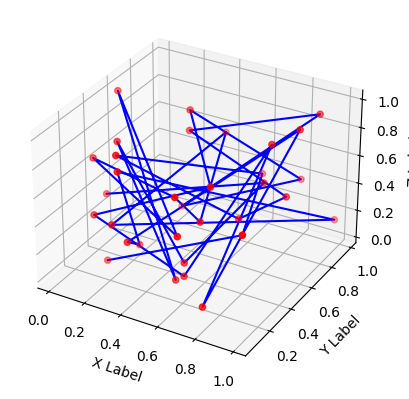

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create an example 3D array with shape (1, 33, 3)
array_3d = np.random.rand(1, 33, 3)

# Extract x, y, and z coordinates from the 3D array
x = array_3d[0, :, 0]
y = array_3d[0, :, 1]
z = array_3d[0, :, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

# Create a line connecting the points
ax.plot(x, y, z, color='b')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


##RNN and CNN



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sample data: You should replace this with your own dataset
# X_train should be a numpy array of shape (num_samples, num_timesteps, num_features)
# Y_train should be a numpy array of shape (num_samples, num_timesteps, num_features)

# Define model parameters
num_timesteps = 10
num_features = 99  # 33 joint coordinates

# Build the many-to-many RNN model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(num_timesteps, num_features)))
model.add(Dense(num_features))  # Output layer with 33 units

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with your data
model.fit(X_train, Y_train, epochs=50, batch_size=32)  # You may need to adjust the batch size and number of epochs

# Predict the next 33 joint coordinates based on the previous 10 timesteps

In [ ]:
# model LSTM

import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(64, input_shape = (33,3), return_sequences=True))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

model.fit(data[:-1], data[1:], epochs=10, batch_size=32)

In [ ]:
# CNN + LSTM based sequence modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

features = data[:-1]
labels = data[1:]

# CNN + LSTM
m_to_m = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape = [33,3]),
    tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
    tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
#     tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
    ])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

m_to_m.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                       optimizer=optimizer,
                       metrics=["mae"])

m_to_m.fit(features[:2000], labels[:2000], epochs=50, batch_size=150, validation_data=(features[2000:], labels[2000:]))


In [ ]:
# model CNN
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D


# # Define your input sequence (assuming you have a 1D sequence of 33 * 3 values)
# input_sequence = np.random.rand(5000, 33, 3)  # Replace this with your actual data

# Choose the number of time steps for input and output
n_steps_in, n_steps_out = 33, 33

# Convert into input/output
# X, y = split_sequences(input_sequence, n_steps_in, n_steps_out)

# Define the number of features (3 features for each of the 33 joints)
n_features = data.shape[2]

# Define the model
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(99,)))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(99, activation='relu'))
model_CNN.add(Dense(n_steps_out * n_features))  # Adjust output shape for your problem

model_CNN.compile(optimizer='adam', loss='mse')

# Fit the model
model_CNN.fit(data[:-1], data[1:], epochs=200, verbose=0)  # Adjust the number of epochs as needed

# Demonstrate prediction
sample_input = data[0].reshape(1, n_steps_in, n_features) # Replace with your input
sample_input = sample_input.reshape(1, 99)
yhat = model_CNN.predict(sample_input, verbose=0)
print(yhat)